In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import regex as re

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

# IO

In [2]:
%matplotlib inline

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [ 

    # dict(name="base_rtol_1e-5", id="t3a-rtol_1e-5_quicktest", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="base_rtol_1e-7", id="t3an-rtol_1e-7_quicktest", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="scale_1e-1", id="t3c-rtol_1e-5_quicktest_corekappa_1e-1", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="scale_1e-3", id="t3cb-rtol_1e-5_quicktest_corekappa_1e-3", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="scale_1e-3_3rings", id="t3cc-rtol_1e-5_quicktest_corekappa_1e-3_3rings", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="scale_1e-3_3rings_ions", id="t3cc-rtol_1e-5_quicktest_corekappa_1e-3_3rings", unnormalise_geom = True, use_xhermes = True, squash = False),
    
    # dict(name="scale_1e-3_3rings_ions", id="t3cc-rtol_1e-5_quicktest_corekappa_1e-3_3rings", unnormalise_geom = True, use_xhermes = True, squash = False),
    
    # dict(name="test_rtol_1e-6", id="t1db-mxorder_off_rtol_1e-6_mergecells", unnormalise_geom = True, use_xhermes = True, squash = False), 
    
    dict(name="test_rtol_1e-6_sundialslogs", id="t1dc-mxorder_off_rtol_1e-6_sundialslogs", unnormalise_geom = True, use_xhermes = True, squash = False), 
    
    # dict(name="orthogonal", id="t1a-base_steady", unnormalise_geom = True, use_xhermes = True, squash = False), 
    # dict(name="nonorthogonal", id="t9a-nonortho_xpoint_dirichlet", unnormalise_geom = True, use_xhermes = True, squash = False), 
    
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].ds.load()


- Reading case t1dc-mxorder_off_rtol_1e-6_sundialslogs
-----------------------


/ssd_scratch/scripts/xBOUT/xbout/load.py:1138: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


In [5]:
diags

['cvode_last_order',
 'cvode_last_step',
 'cvode_nfevals',
 'cvode_nliters',
 'cvode_nniters',
 'cvode_nonlin_fails',
 'cvode_npevals',
 'cvode_nsteps',
 'cvode_num_fails',
 'cvode_stab_lims']

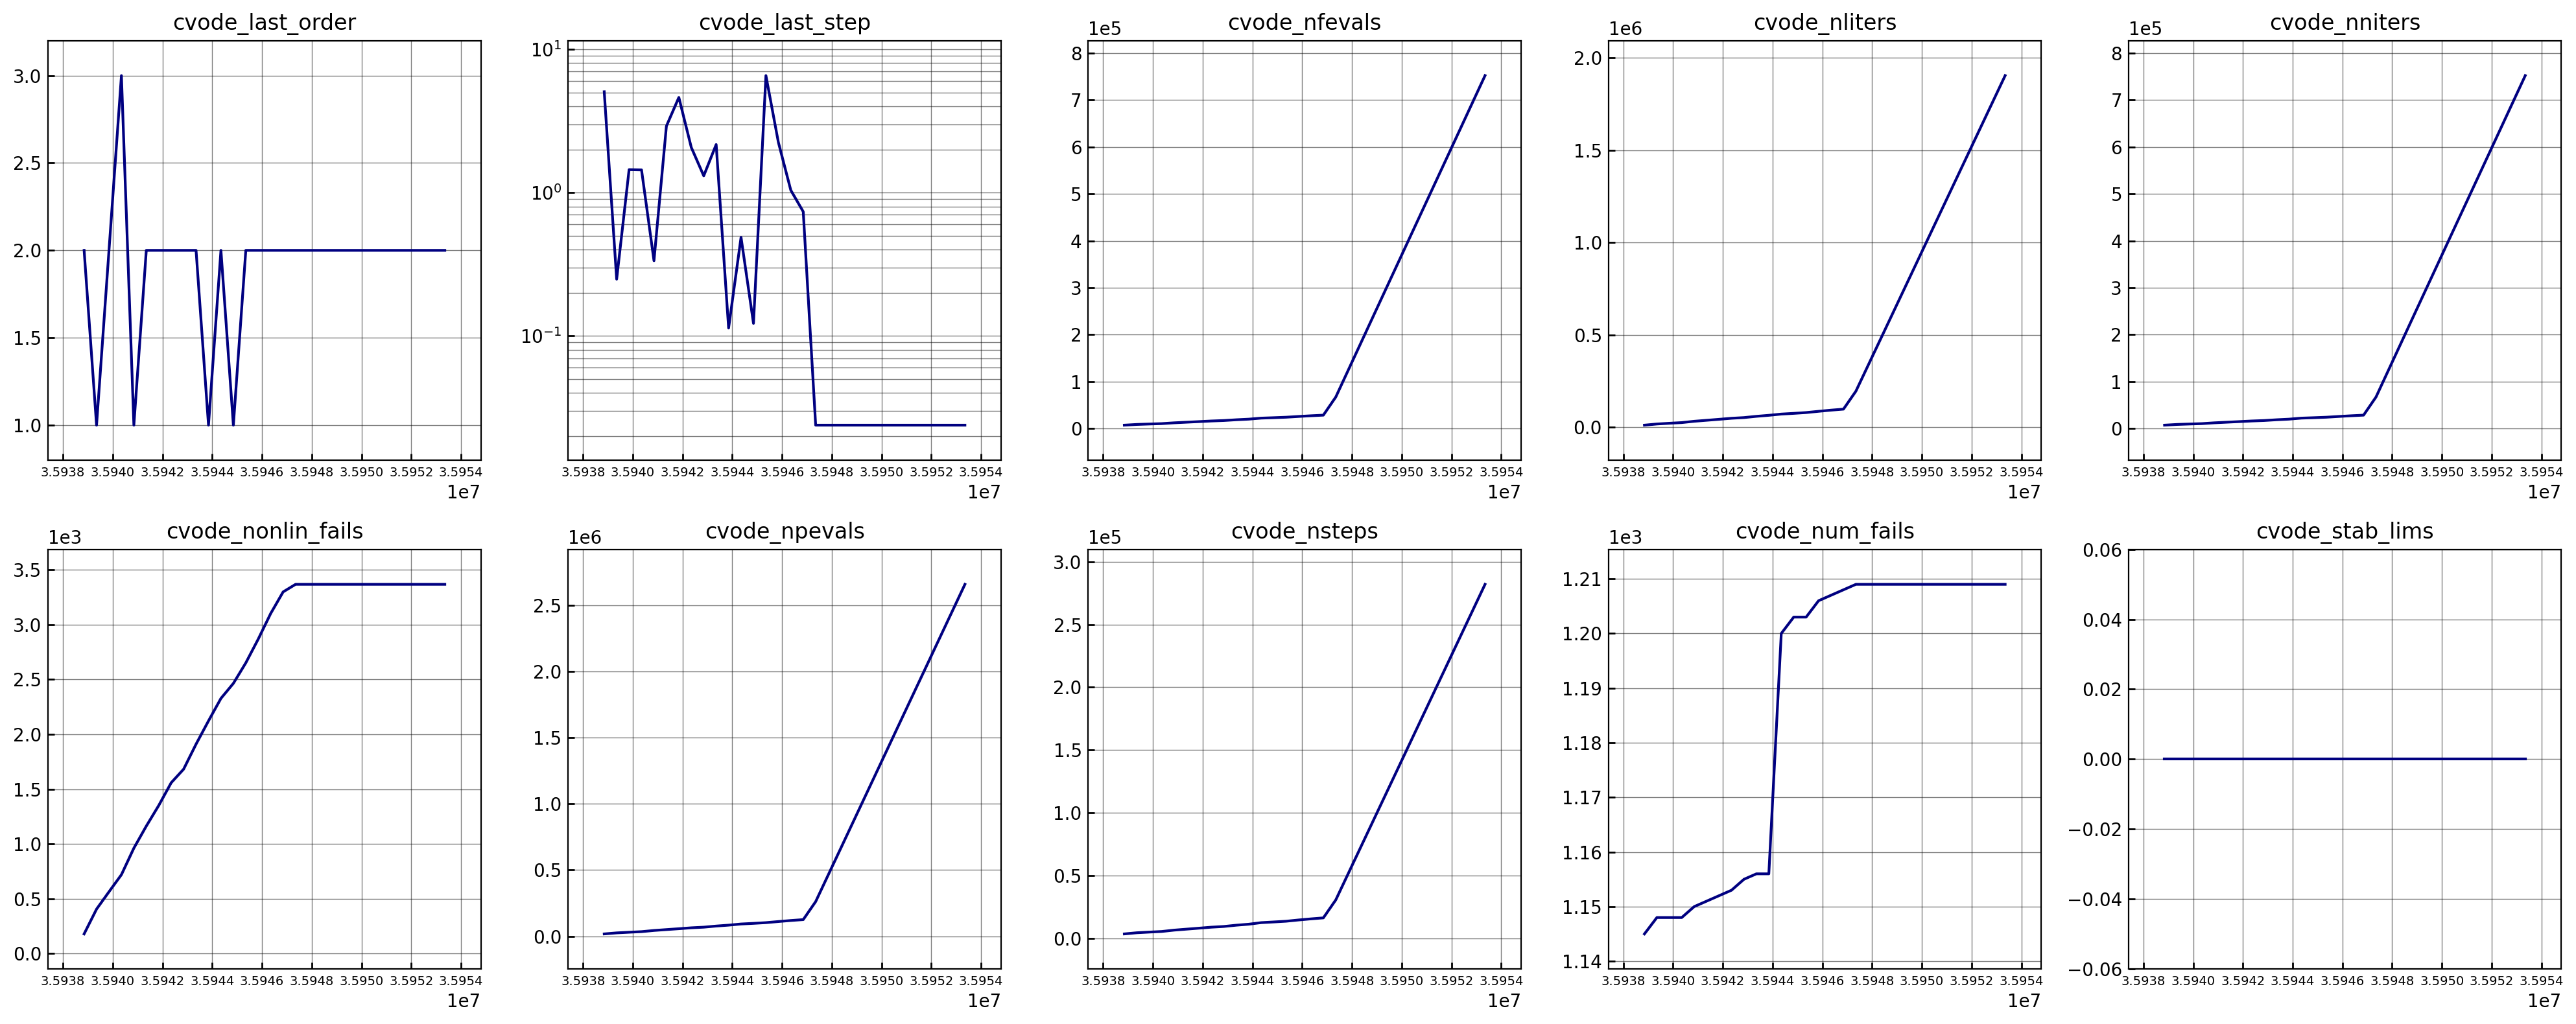

In [32]:
ds = cs["test_rtol_1e-6_sundialslogs"].ds
diags = [x for x in ds.data_vars if "cvode" in x]

t = ds["t"]/ds["t"].attrs["conversion"]

size = 4
fig, axes = plt.subplots(2,5, figsize = (size*5, size*2), dpi = 200)

for i, diag in enumerate(diags):
    
    if i > 4:
        j = 1
        i -= 5
    else:
        j = 0
        
    if "last_step" in diag:
        axes[j, i].set_yscale("log")
    axes[j, i].plot(t[1:], ds[diag][1:], label = diag, c = "navy")
    axes[j, i].set_title(diag)
    # axes[j, i].set_xlabel
    axes[j, i].xaxis.set_major_locator(mpl.ticker.MaxNLocator(10))
    plt.setp(axes[j, i].get_xticklabels(), fontsize=7)  # Set the font size of the X tick labels
    axes[j, i].grid(which = "both", color = "k", alpha = 0.5)
    
fig.tight_layout()

# Convergence

GUARD REPLACEMENT IS WRONG - FIX ME


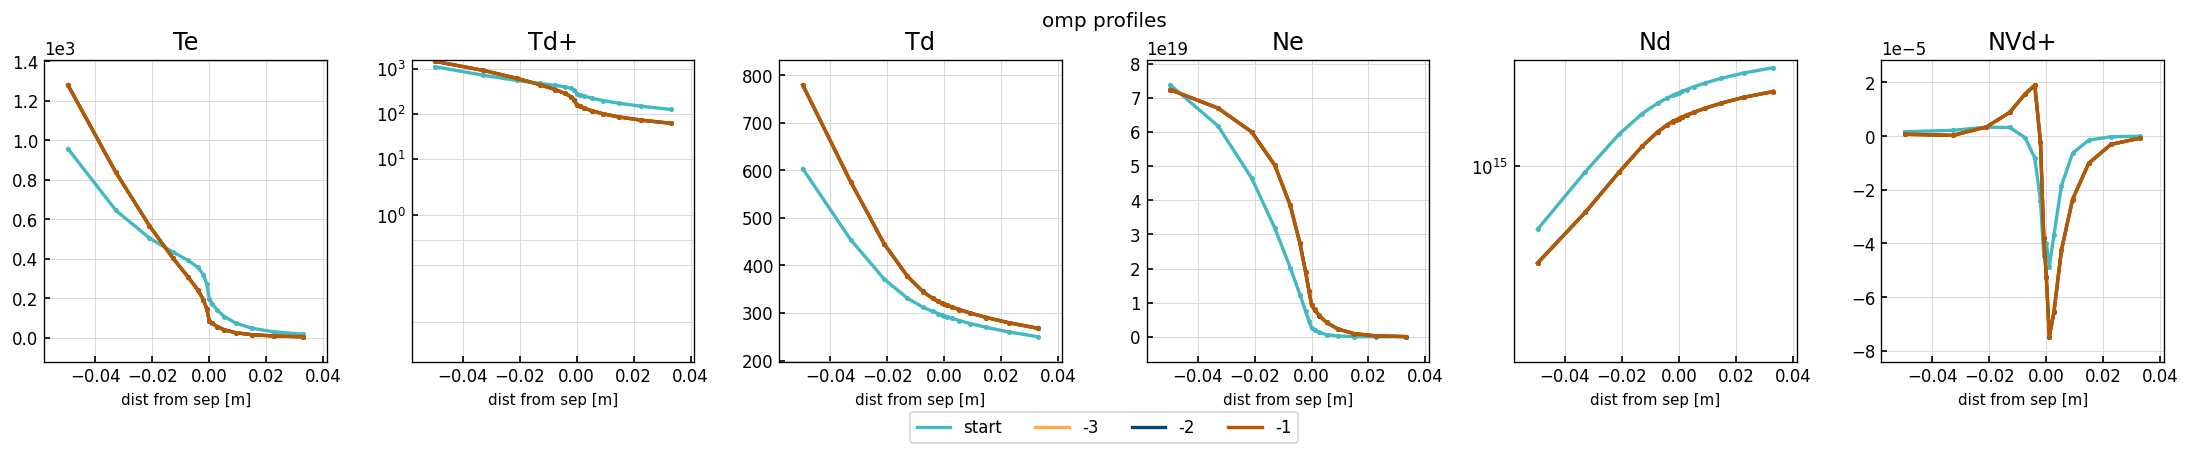

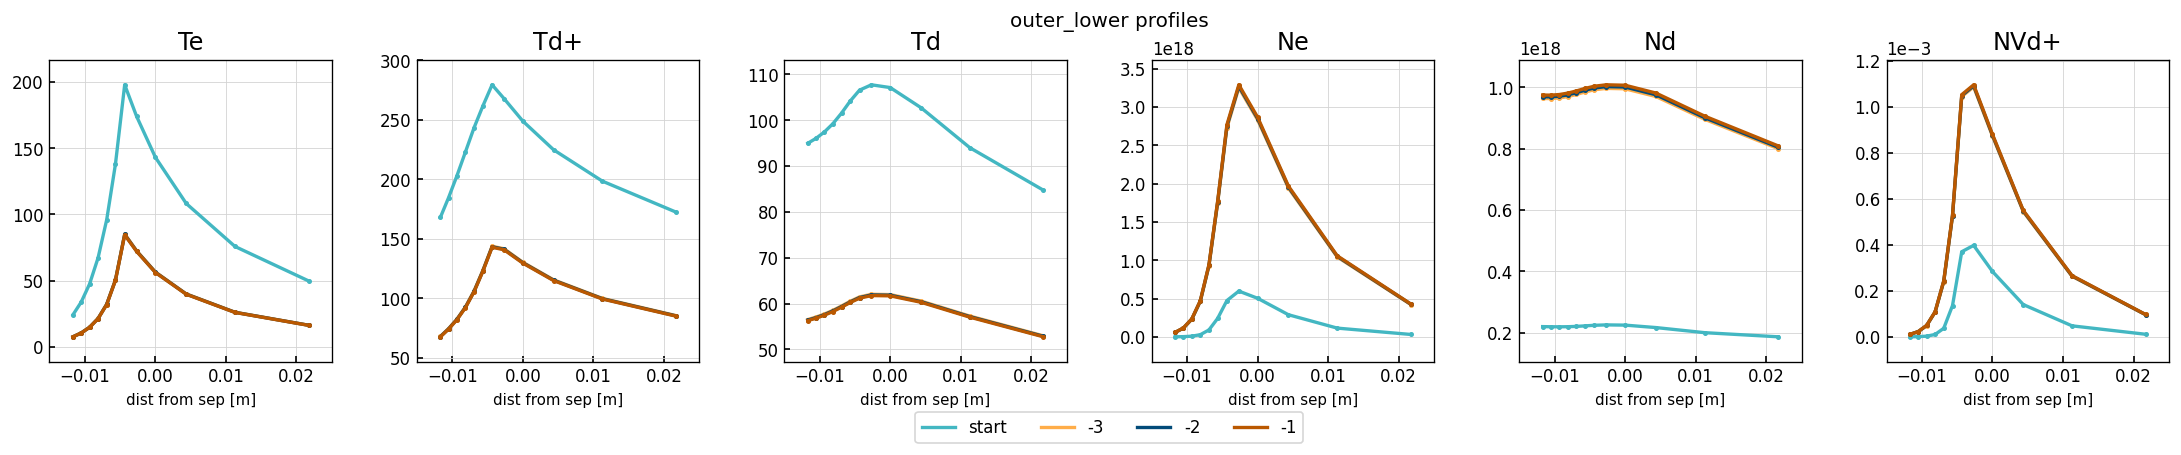

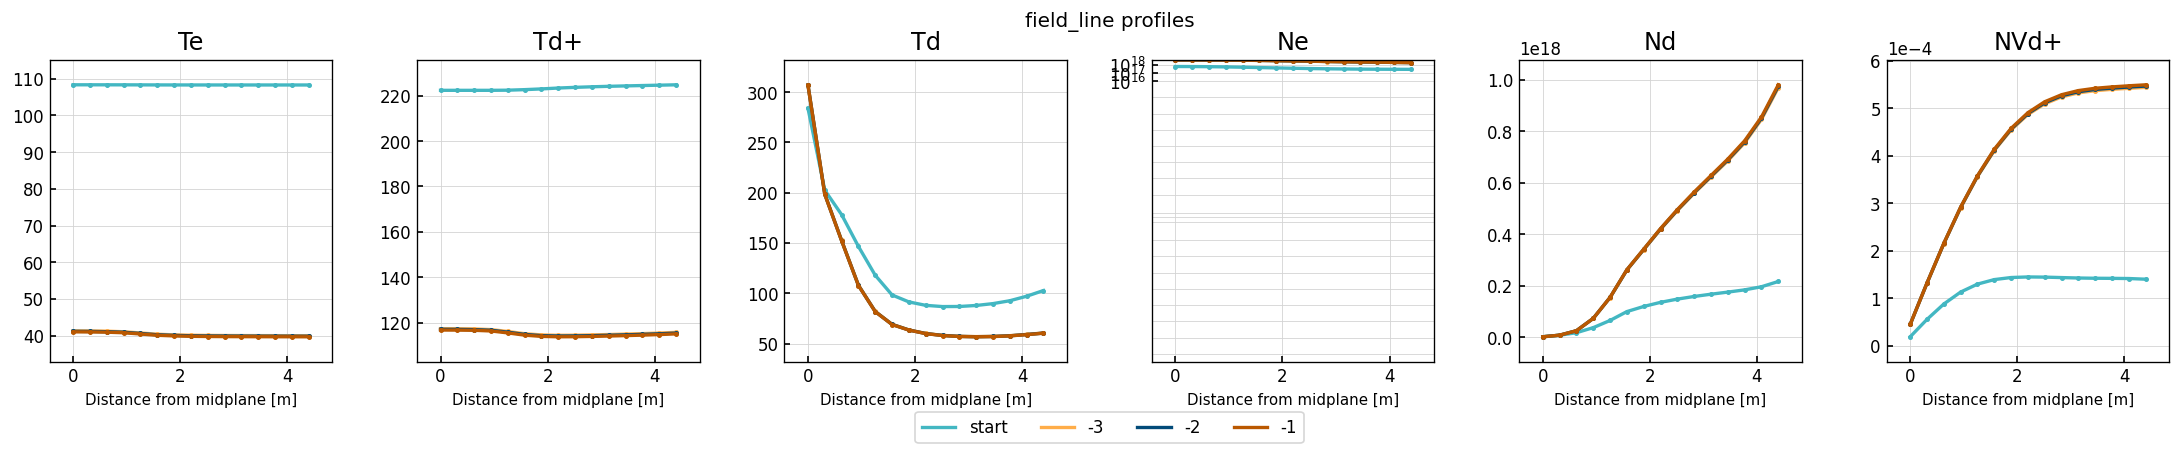

In [4]:
case = "nonorthogonal"
lineplot(
    {
        "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        "-3":cs[case].ds.isel(t=-3, x = slice(2,-2)),
        "-2":cs[case].ds.isel(t=-2, x = slice(2,-2)),
        "-1":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    guard_replace = False,
    params = ["Te", "Td+", "Td", "Ne", "Nd", "NVd+"],
    regions = ["omp", "outer_lower", "field_line"],
)

# Case comparison

GUARD REPLACEMENT IS WRONG - FIX ME


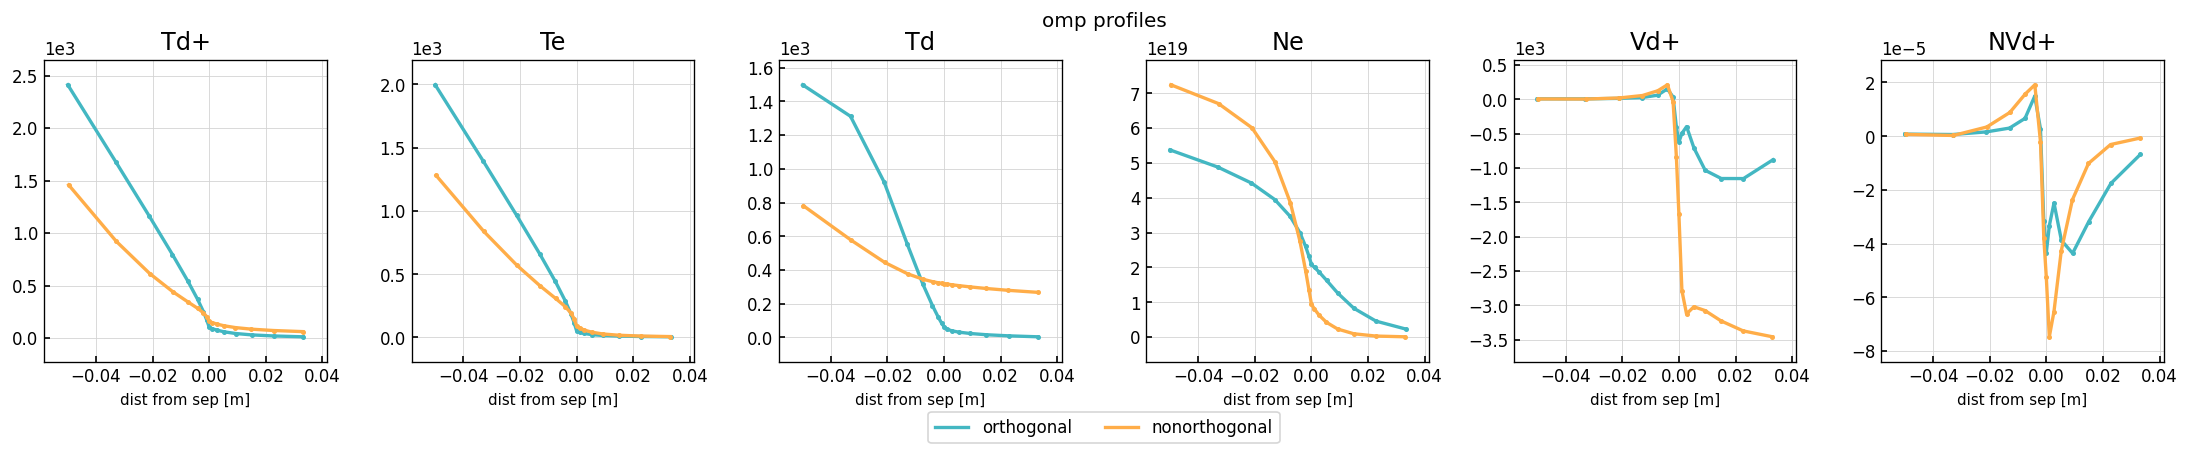

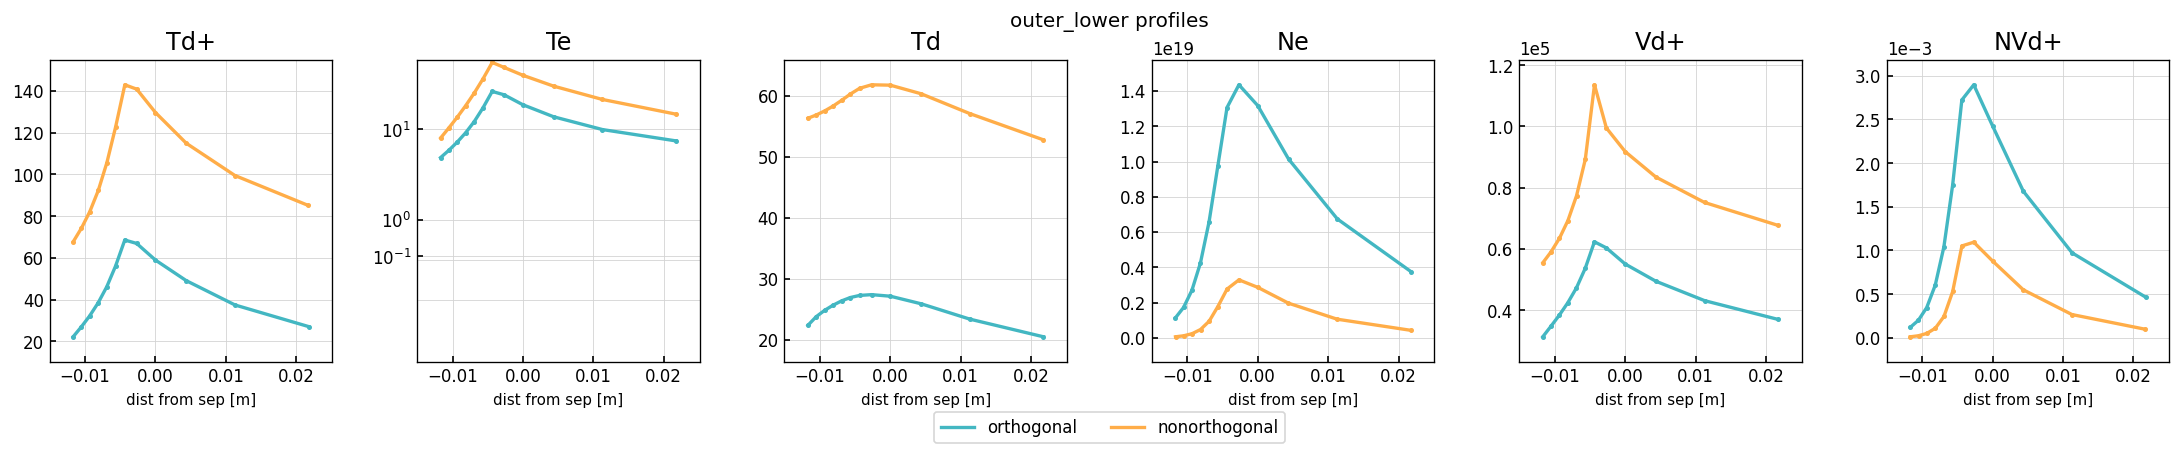

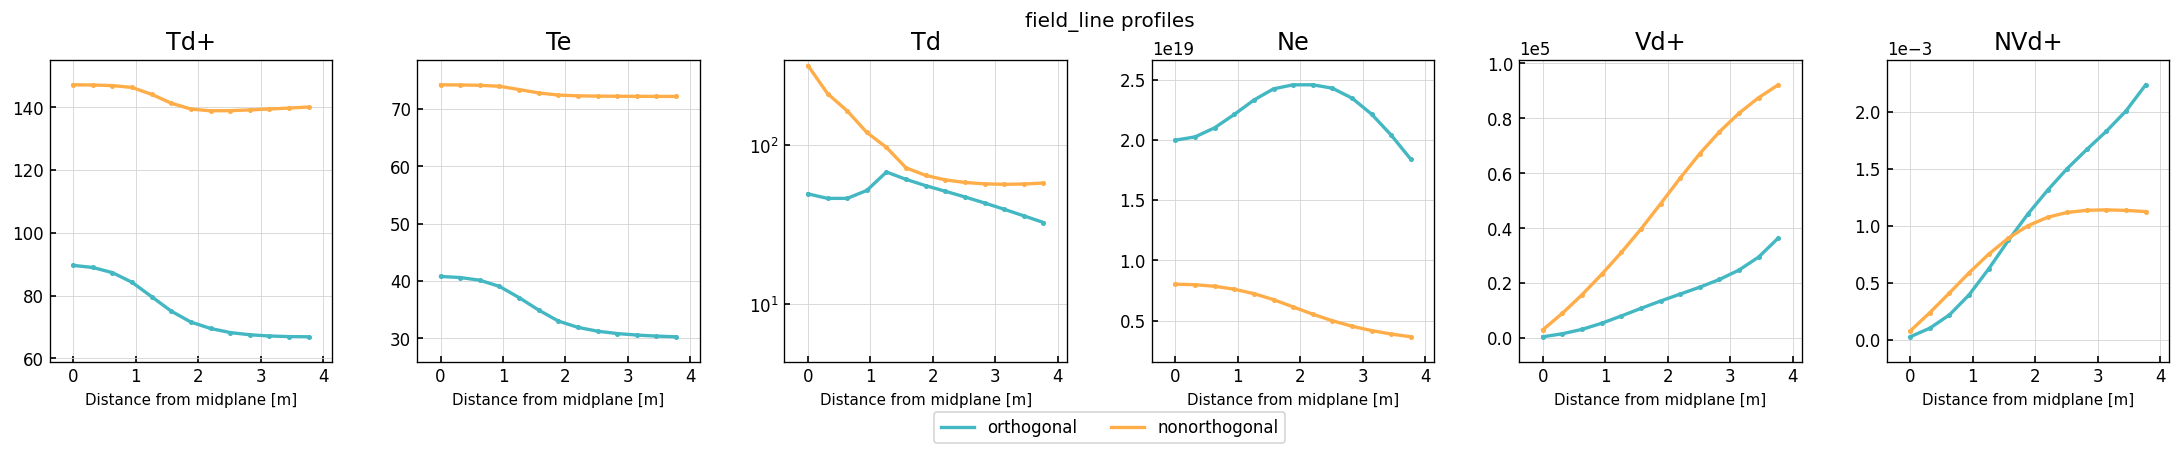

In [5]:
toplot = {}
for name in cs:
# for name in ["diags"]:
    ds = cs[name].ds
    if "t" in ds.dims:
        ds = ds.isel(t=-1)
    toplot[name] = ds

lineplot(
    toplot,
    clean_guards = True,
    guard_replace = False,
    params = ["Td+", "Te", "Td", "Ne", "Vd+", "NVd+"],
    regions = ["omp", "outer_lower", "field_line"],
    # xlims=(29.8,30)
    # xlims=(0,1)
)

In [14]:
(1+0.24)/(1+4.2) * 13.58 * 3/4 * np.pi

7.630082742162871

# Performance

In [12]:
%matplotlib inline

In [25]:
# cs["pvode_4cores"].ds.hermesm.get_cvode_metrics()
dict_ds = {}
for case in cs:
    dict_ds[case] = cs[case].ds
    
plot_cvode_performance(dict_ds, logscale = False)

IndexError: too many indices

In [4]:
%matplotlib inline

# ddt(Pe) fluctuations

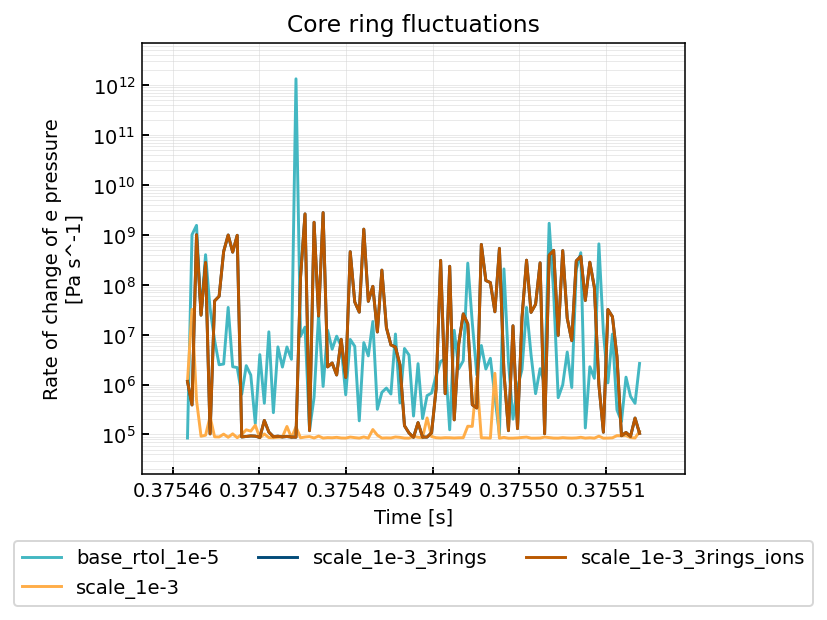

In [4]:
fig, ax = plt.subplots()

for case in cs:
    ds = cs[case].ds
    core = ds.hermesm.select_region("core_edge")
    core["ddt(Pe)"].max("theta").plot(ax = ax, label = case)
    
ax.set_title("Core ring fluctuations")
ax.set_yscale("log")
ax.legend(loc = "upper center", bbox_to_anchor = (0.5, -0.15), ncols = 3)

# 2D kappa plot

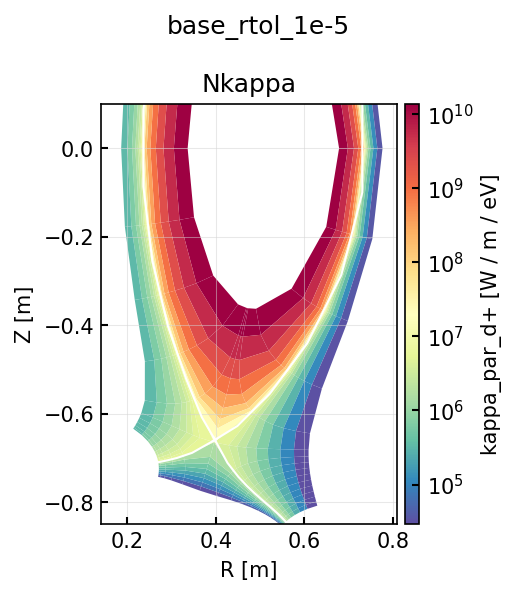

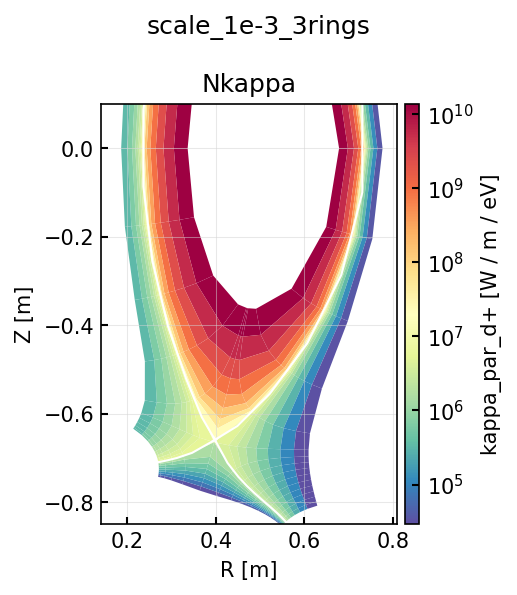

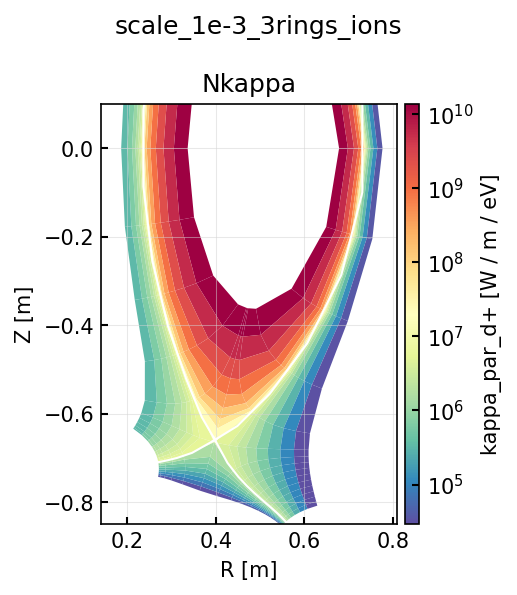

In [22]:
# for case in ["a1_mfp1e-4"]:
for case in cs:
    ds = cs[case].ds
    
    if "t" in ds.dims:
        ds = ds.isel(t=-1)
        
    plot2d(
        [
            dict(data = ds["kappa_par_d+"].hermesm.clean_guards(), title = "Nkappa", vmin = None, vmax = None, logscale = True),

            ], 
            ylim = (-0.85, 0.1),
            title = f"{case}")

# Animation

In [9]:
%matplotlib widget

In [10]:
cs.keys()

dict_keys(['orthogonal', 'nonorthogonal'])

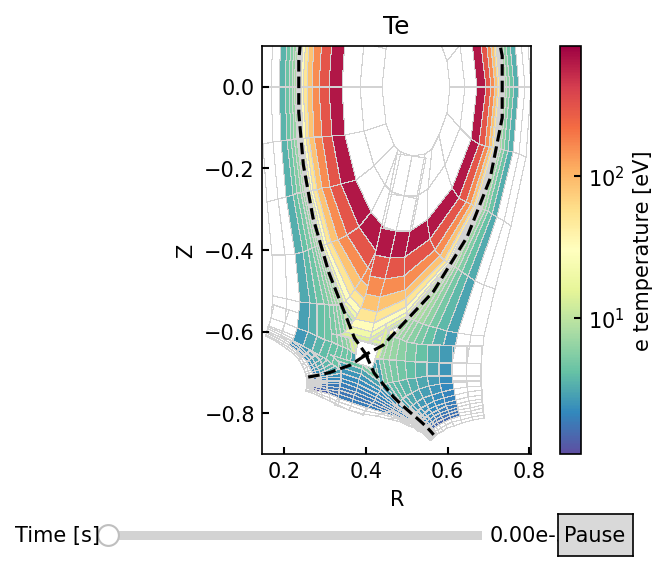

In [13]:
plt.close("all")

ds = cs["nonorthogonal"].ds

fig, ax = plt.subplots(dpi = 150)

anim = xbout.plotting.animate.animate_poloidal(
    (ds["Te"]).hermesm.clean_guards(), ax = ax, 
    cmap = "Spectral_r",
    targets = False,
    logscale = True,
    # vmin = -1e11,
    # vmax = 1e11,
    # vmin = -1e-3, vmax = 1e-3,
    color = "lightgrey",
    lw = 0.01)

ax.set_ylim(-0.9, 0.1)
ax.grid(False)